# CIFAR-100 Evaluation Metrics

Notebook này hiển thị các calibration metrics trên test set cho các phương pháp khác nhau.

In [10]:
# Setup imports
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd



from src.infer import (
    DATASET, DEVICE, OUTPUT_DIR,
    EXPERT_NAMES, NUM_CLASSES,
    load_gating_network
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports successful!")

✅ Imports successful!


### 7.1 Calibration Metrics Comparison

So sánh các calibration metrics trên test set:
- **NLL (Negative Log-Likelihood)**: Đo độ chính xác và calibration
- **Brier Score**: Đo độ chính xác của probabilistic predictions
- **Max-prob ECE**: Expected Calibration Error dựa trên max probability
- **Class-wise ECE**: Expected Calibration Error theo từng class

In [11]:
from src.metrics.plot_combined_metrics_line import (
    compute_nll,
    compute_brier_score,
    compute_max_prob_ece,
    compute_classwise_ece
)

logits_dir = Path(f"./outputs/logits/{DATASET}")
test_logits_available = (logits_dir / "ce_baseline" / "test_logits.pt").exists()

if test_logits_available:
    print("="*70)
    print("COMPREHENSIVE CALIBRATION METRICS COMPARISON")
    print("="*70)
    print("\n📊 Computing calibration metrics on test set...")
    print("   (This may take a few moments...)\n")
    
    import torchvision
    dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
    splits_dir = Path(f"./data/{DATASET}_splits_fixed")
    with open(splits_dir / "test_indices.json", "r") as f:
        test_indices = json.load(f)
    test_labels = torch.tensor([dataset.targets[i] for i in test_indices], dtype=torch.long, device=DEVICE)
    
    counts_path = splits_dir / "train_class_counts.json"
    with open(counts_path, "r") as f:
        class_counts = json.load(f)
    if isinstance(class_counts, dict):
        class_counts = [class_counts[str(i)] for i in range(NUM_CLASSES)]
    counts = np.array(class_counts, dtype=np.float64)
    total_train = counts.sum()
    train_probs = counts / total_train
    weights = train_probs * NUM_CLASSES
    class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    
    posteriors = {}
    
    for expert_name in EXPERT_NAMES:
        logits = torch.load(logits_dir / expert_name / "test_logits.pt", map_location=DEVICE).float()
        posteriors[expert_name] = F.softmax(logits, dim=-1)
    
    # Compute gating mixture posterior
    expert_logits_all = torch.stack([
        torch.load(logits_dir / name / "test_logits.pt", map_location=DEVICE).float()
        for name in EXPERT_NAMES
    ], dim=0).transpose(0, 1)  # [N, 3, 100]
    
    if 'gating_net' not in locals():
        gating_net = load_gating_network()
    
    posteriors["gating_mixture"] = gating_net.get_mixture_posterior_from_logits(expert_logits_all)
    
    methods = ["ce_baseline", "logitadjust_baseline", "balsoftmax_baseline", "gating_mixture"]
    display_names = {
        "ce_baseline": "CE Baseline",
        "logitadjust_baseline": "LogitAdjust",
        "balsoftmax_baseline": "BalSoftmax",
        "gating_mixture": "Gating Mixture",
    }
    
    print("Computing metrics...")
    nll_vals, brier_vals, max_ece_vals, cw_ece_vals = [], [], [], []
    calibration_metrics = {}
    
    for method_name in methods:
        posterior = posteriors[method_name]
        
        nll = compute_nll(posterior, test_labels, class_weights=class_weights)
        brier = compute_brier_score(posterior, test_labels, class_weights=class_weights)
        max_ece = compute_max_prob_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        cw_ece = compute_classwise_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        
        nll_vals.append(nll)
        brier_vals.append(brier)
        max_ece_vals.append(max_ece)
        cw_ece_vals.append(cw_ece)
        
        calibration_metrics[method_name] = {
            'nll': nll,
            'brier': brier,
            'max_ece': max_ece,
            'cw_ece': cw_ece
        }
        
        print(f"  {display_names[method_name]:<20} NLL={nll:.4f} Brier={brier:.4f} "
              f"Max-ECE={max_ece:.4f} cw-ECE={cw_ece:.4f}")
    
    # Store for plotting
    calibration_metrics['_methods'] = methods
    calibration_metrics['_display_names'] = display_names
    calibration_metrics['_nll_vals'] = nll_vals
    calibration_metrics['_brier_vals'] = brier_vals
    calibration_metrics['_max_ece_vals'] = max_ece_vals
    calibration_metrics['_cw_ece_vals'] = cw_ece_vals
    
    print("\n✅ Calibration metrics computed for all methods!")
else:
    print("⚠️  Test logits not available. Skipping calibration metrics computation.")
    print(f"    (Test logits required: outputs/logits/{DATASET}/*/test_logits.pt)")
    calibration_metrics = None


COMPREHENSIVE CALIBRATION METRICS COMPARISON

📊 Computing calibration metrics on test set...
   (This may take a few moments...)

Computing metrics...
  CE Baseline          NLL=1.8542 Brier=0.5370 Max-ECE=0.1912 cw-ECE=0.0046
  LogitAdjust          NLL=1.5281 Brier=0.4964 Max-ECE=0.0465 cw-ECE=0.0053
  BalSoftmax           NLL=1.6492 Brier=0.5144 Max-ECE=0.0798 cw-ECE=0.0054
  Gating Mixture       NLL=1.3789 Brier=0.4528 Max-ECE=0.0800 cw-ECE=0.0036

✅ Calibration metrics computed for all methods!


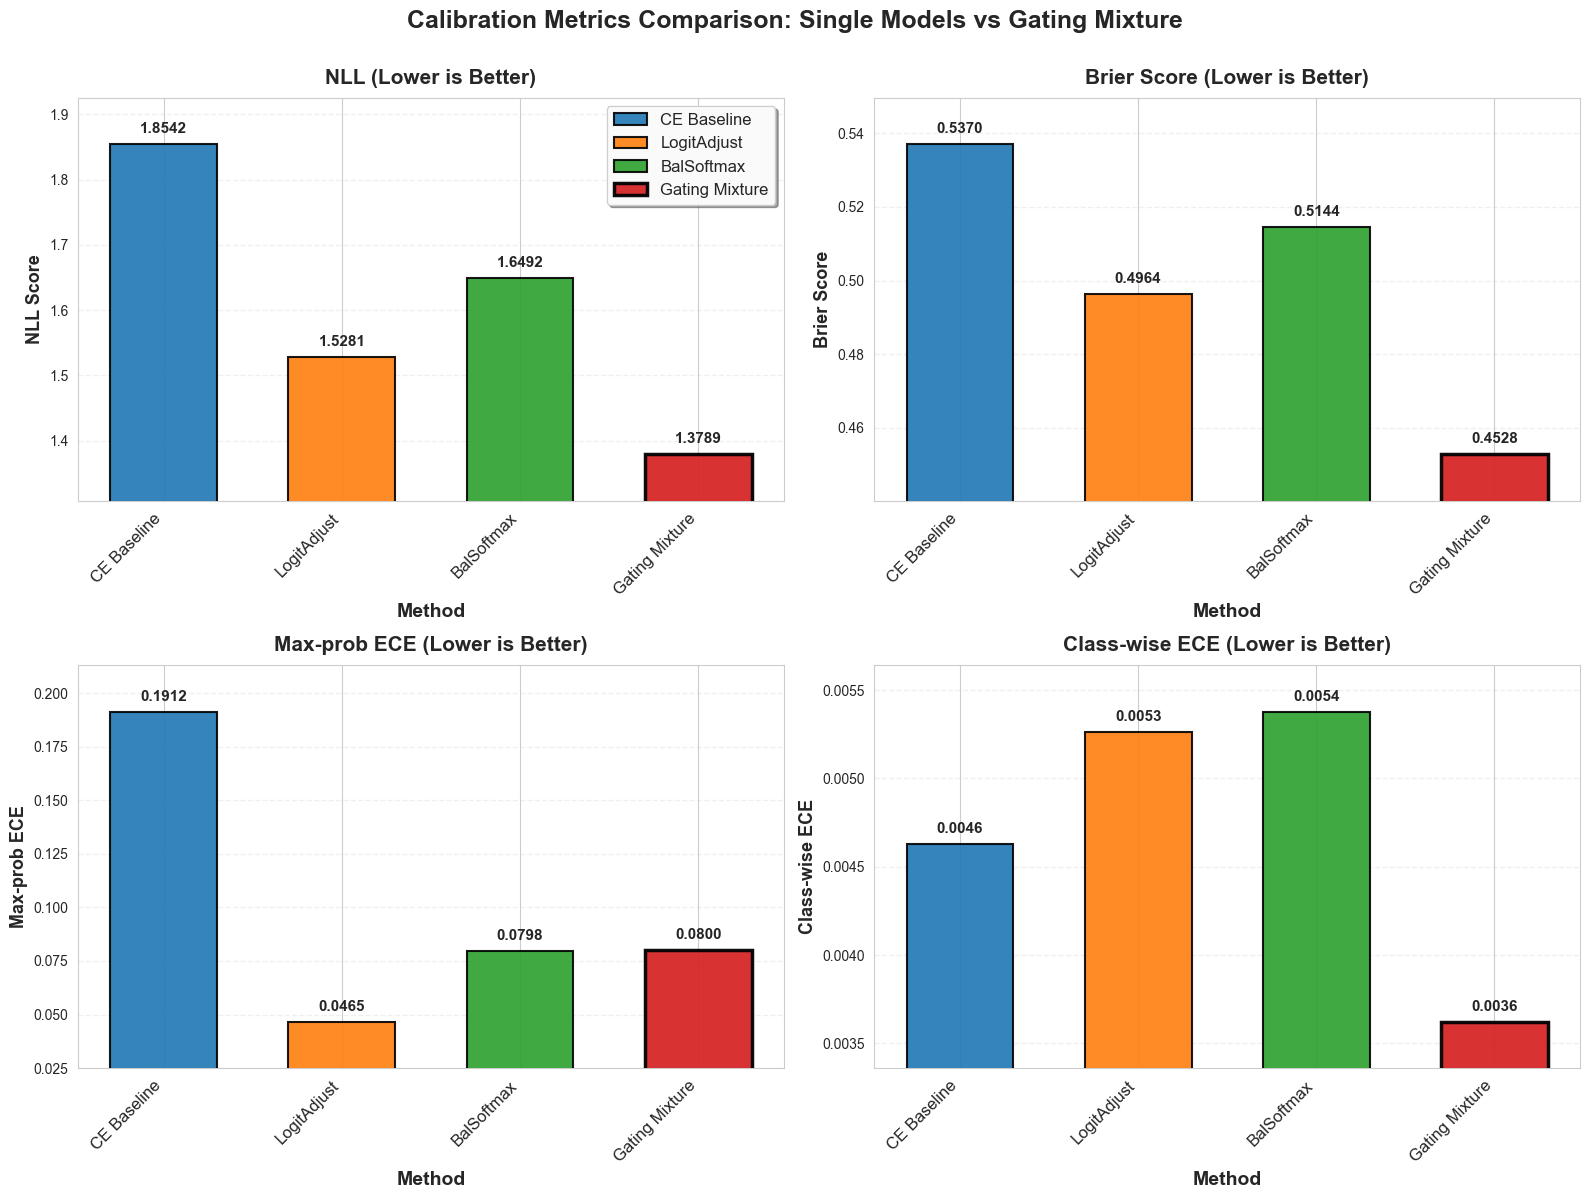


💡 Lower values are better for all metrics.
   This plot shows the raw metric values for all 4 methods.
   Each subplot displays one calibration metric comparison.


In [12]:
if calibration_metrics is not None and '_methods' in calibration_metrics:
    
    # Extract data
    methods = calibration_metrics['_methods']
    display_names = calibration_metrics['_display_names']
    method_labels = [display_names[m] for m in methods]
    
    nll_vals = calibration_metrics['_nll_vals']
    brier_vals = calibration_metrics['_brier_vals']
    max_ece_vals = calibration_metrics['_max_ece_vals']
    cw_ece_vals = calibration_metrics['_cw_ece_vals']
    
    # Define colors for each method (consistent with other plots)
    method_colors = {
        "CE Baseline": "#1f77b4",      # Blue
        "LogitAdjust": "#ff7f0e",       # Orange
        "BalSoftmax": "#2ca02c",        # Green
        "Gating Mixture": "#d62728",    # Red
    }
    
    # Create 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Calibration Metrics Comparison: Single Models vs Gating Mixture',
                 fontsize=18, fontweight='bold', y=0.995)
    
    metrics_info = [
        ("NLL", nll_vals, "NLL Score"),
        ("Brier Score", brier_vals, "Brier Score"),
        ("Max-prob ECE", max_ece_vals, "Max-prob ECE"),
        ("Class-wise ECE", cw_ece_vals, "Class-wise ECE"),
    ]
    
    for idx, (metric_name, raw_vals, ylabel) in enumerate(metrics_info):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Use raw values (no normalization)
        vals = raw_vals
        
        # Set up bar positions
        x = np.arange(len(method_labels))
        width = 0.6
        
        bars = []
        for i, method in enumerate(method_labels):
            color = method_colors.get(method, 'gray')
            edgewidth = 2.5 if method == "Gating Mixture" else 1.5
            alpha = 0.95 if method == "Gating Mixture" else 0.9
            
            bar = ax.bar(i, vals[i], width, 
                        label=method if idx == 0 else "",  # Only label in first subplot
                        color=color, alpha=alpha,
                        edgecolor='black', linewidth=edgewidth, zorder=5)
            bars.append(bar)
        
        # Calculate y-axis limits based on actual values
        max_val = max(vals)
        min_val = min(vals)
        y_range = max_val - min_val
        y_margin = y_range * 0.15 if y_range > 0 else max_val * 0.1
        y_min = max(0, min_val - y_margin)
        y_max = max_val + y_margin
        
        # Formatting
        ax.set_xlabel('Method', fontsize=14, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
        ax.set_title(f'{metric_name} (Lower is Better)', fontsize=15, fontweight='bold', pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(method_labels, rotation=45, ha='right', fontsize=12)
        ax.set_ylim([y_min, y_max])
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0, axis='y', zorder=0)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = vals[i]
            label_y = height + (y_max - y_min) * 0.02
            ax.text(i, label_y, f'{height:.4f}', 
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    axes[0, 0].legend(loc='upper right', fontsize=12, framealpha=0.95,
                     fancybox=True, shadow=True, ncol=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    print("\n💡 Lower values are better for all metrics.")
    print("   This plot shows the raw metric values for all 4 methods.")
    print("   Each subplot displays one calibration metric comparison.")
else:
    print("⚠️  Calibration metrics not available. Please run the previous cell first.")


# TO DO: Plot lại các bảng, bỏ brier score

=== Data Loading Summary ===
✓ CE Only (Balanced): 9 points
✓ CE Only (Worst): 9 points
✓ ARE (Balanced): 9 points
✓ ARE (Worst): 10 points

✓ CE Only (Balanced) data range:
  Rejection rates: [0.000, 0.800]
  Tail - Head errors: [0.117, 0.352]

✓ CE Only (Worst) data range:
  Rejection rates: [0.000, 0.800]
  Tail - Head errors: [0.056, 0.105]

✓ ARE (Balanced) data range:
  Rejection rates: [0.000, 0.800]
  Tail - Head errors: [0.014, 0.172]

✓ ARE (Worst) data range:
  Rejection rates: [0.000, 0.900]
  Tail - Head errors: [0.000, 0.096]

✓ Saved plot to: ./results/paper_figures/head_tail_error_comparison.png


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_3555/683944967.py:234: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_3555/683944967.py:234: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_3555/683944967.py:234: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_3555/683944967.py:234: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_3555/683944967.py:234: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


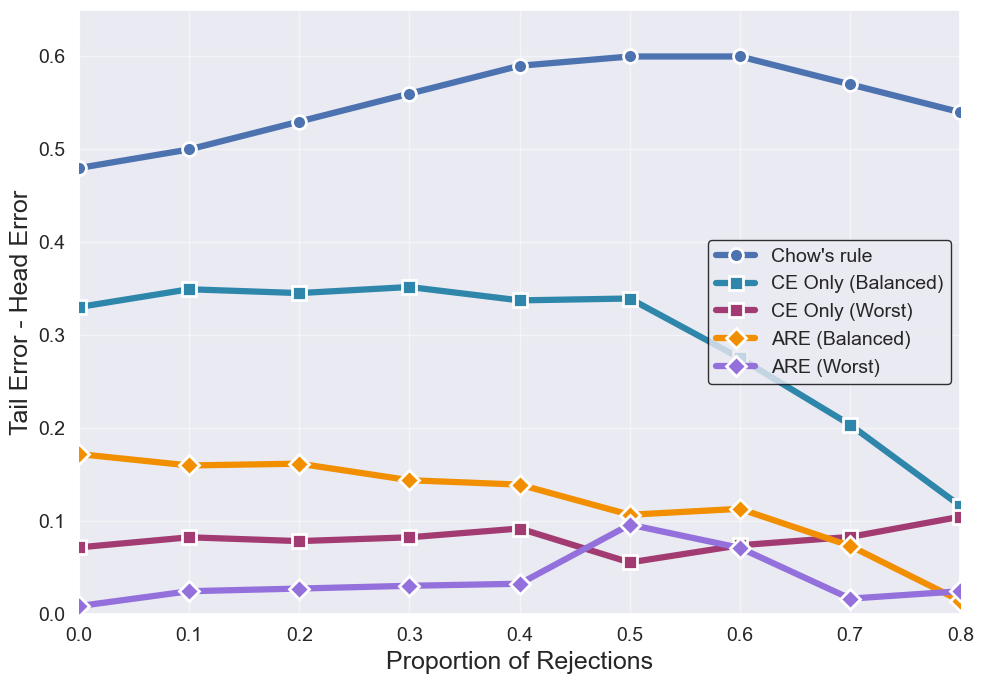

In [13]:
# --- 1. Load dữ liệu từ JSON files ---
def load_head_tail_error_data(json_path: str, method_name: str):
    """Load dữ liệu Tail Error - Head Error từ JSON file."""
    json_file = Path(json_path)
    if not json_file.exists():
        print(f"Warning: {json_path} not found. Skipping {method_name} data.")
        return None, None
    
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    rejection_rates = []
    tail_minus_head_errors = []
    
    # Extract từ results_per_cost (cho balanced methods)
    if 'results_per_cost' in data:
        for result in data['results_per_cost']:
            test_metrics = result.get('test_metrics', {})
            group_errors = test_metrics.get('group_errors', [])
            
            if len(group_errors) >= 2:
                head_error = float(group_errors[0])
                tail_error = float(group_errors[1])
                tail_minus_head = tail_error - head_error
                
                # Lấy rejection_rate từ test_metrics hoặc tính từ coverage
                rejection_rate = test_metrics.get('rejection_rate', None)
                if rejection_rate is None:
                    coverage = test_metrics.get('coverage', 1.0)
                    rejection_rate = 1.0 - coverage
                
                rejection_rates.append(float(rejection_rate))
                tail_minus_head_errors.append(tail_minus_head)
    
    # Extract từ results_per_point (cho worst methods)
    elif 'results_per_point' in data:
        for result in data['results_per_point']:
            test_metrics = result.get('test_metrics', {})
            group_errors = test_metrics.get('group_errors', [])
            
            if len(group_errors) >= 2:
                head_error = float(group_errors[0])
                tail_error = float(group_errors[1])
                tail_minus_head = tail_error - head_error
                
                # Lấy rejection_rate từ target_rejection hoặc tính từ coverage
                rejection_rate = result.get('target_rejection', None)
                if rejection_rate is None:
                    coverage = test_metrics.get('coverage', 1.0)
                    rejection_rate = 1.0 - coverage
                
                rejection_rates.append(float(rejection_rate))
                tail_minus_head_errors.append(tail_minus_head)
    
    if len(rejection_rates) > 0:
        # Sort theo rejection_rate
        sorted_indices = np.argsort(rejection_rates)
        rejection_rates = np.array(rejection_rates)[sorted_indices]
        tail_minus_head_errors = np.array(tail_minus_head_errors)[sorted_indices]
        return rejection_rates, tail_minus_head_errors
    
    return None, None

# Load dữ liệu từ các file JSON
ce_only_balanced_rejections, ce_only_balanced_errors = load_head_tail_error_data(
    './results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_balanced.json',
    'CE Only (Balanced)'
)

ce_only_worst_rejections, ce_only_worst_errors = load_head_tail_error_data(
    './results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_worst.json',
    'CE Only (Worst)'
)

gating_balanced_rejections, gating_balanced_errors = load_head_tail_error_data(
    './results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_balanced.json',
    'ARE (Balanced)'
)

gating_worst_rejections, gating_worst_errors = load_head_tail_error_data(
    './results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_worst.json',
    'ARE (Worst)'
)

# In thông tin để xác nhận đã load dữ liệu
print("=== Data Loading Summary ===")
if ce_only_balanced_rejections is not None:
    print(f"✓ CE Only (Balanced): {len(ce_only_balanced_rejections)} points")
if ce_only_worst_rejections is not None:
    print(f"✓ CE Only (Worst): {len(ce_only_worst_rejections)} points")
if gating_balanced_rejections is not None:
    print(f"✓ ARE (Balanced): {len(gating_balanced_rejections)} points")
if gating_worst_rejections is not None:
    print(f"✓ ARE (Worst): {len(gating_worst_rejections)} points")

# --- 2. Dữ liệu Chow's rule (từ paper) ---
chow_rejections = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
chow_errors = np.array([0.48, 0.50, 0.53, 0.56, 0.59, 0.60, 0.60, 0.57, 0.54])

# --- 3. Chuẩn bị dữ liệu cho DataFrame ---
data_dict = {
    'Proportion of Rejections': chow_rejections,
    "Chow's rule": chow_errors,
}

# Thêm dữ liệu CE Only (Balanced)
if ce_only_balanced_rejections is not None and ce_only_balanced_errors is not None:
    print(f"\n✓ CE Only (Balanced) data range:")
    print(f"  Rejection rates: [{float(ce_only_balanced_rejections.min()):.3f}, {float(ce_only_balanced_rejections.max()):.3f}]")
    print(f"  Tail - Head errors: [{float(ce_only_balanced_errors.min()):.3f}, {float(ce_only_balanced_errors.max()):.3f}]")

# Thêm dữ liệu CE Only (Worst)
if ce_only_worst_rejections is not None and ce_only_worst_errors is not None:
    print(f"\n✓ CE Only (Worst) data range:")
    print(f"  Rejection rates: [{float(ce_only_worst_rejections.min()):.3f}, {float(ce_only_worst_rejections.max()):.3f}]")
    print(f"  Tail - Head errors: [{float(ce_only_worst_errors.min()):.3f}, {float(ce_only_worst_errors.max()):.3f}]")

# Thêm dữ liệu ARE (Balanced)
if gating_balanced_rejections is not None and gating_balanced_errors is not None:
    print(f"\n✓ ARE (Balanced) data range:")
    print(f"  Rejection rates: [{float(gating_balanced_rejections.min()):.3f}, {float(gating_balanced_rejections.max()):.3f}]")
    print(f"  Tail - Head errors: [{float(gating_balanced_errors.min()):.3f}, {float(gating_balanced_errors.max()):.3f}]")

# Thêm dữ liệu ARE (Worst)
if gating_worst_rejections is not None and gating_worst_errors is not None:
    print(f"\n✓ ARE (Worst) data range:")
    print(f"  Rejection rates: [{float(gating_worst_rejections.min()):.3f}, {float(gating_worst_rejections.max()):.3f}]")
    print(f"  Tail - Head errors: [{float(gating_worst_errors.min()):.3f}, {float(gating_worst_errors.max()):.3f}]")

# Chuyển dữ liệu Chow sang DataFrame
df_chow = pd.DataFrame(data_dict)
df_chow_melted = df_chow.melt(
    id_vars=['Proportion of Rejections'],
    var_name='Method',
    value_name='Tail Error - Head Error'
)

# Tạo DataFrame cho các phương pháp từ JSON
dfs_list = [df_chow_melted]

if ce_only_balanced_rejections is not None and ce_only_balanced_errors is not None:
    df_ce_bal = pd.DataFrame({
        'Proportion of Rejections': ce_only_balanced_rejections,
        'CE Only (Balanced)': ce_only_balanced_errors
    })
    df_ce_bal_melted = df_ce_bal.melt(
        id_vars=['Proportion of Rejections'],
        var_name='Method',
        value_name='Tail Error - Head Error'
    )
    dfs_list.append(df_ce_bal_melted)

if ce_only_worst_rejections is not None and ce_only_worst_errors is not None:
    df_ce_worst = pd.DataFrame({
        'Proportion of Rejections': ce_only_worst_rejections,
        'CE Only (Worst)': ce_only_worst_errors
    })
    df_ce_worst_melted = df_ce_worst.melt(
        id_vars=['Proportion of Rejections'],
        var_name='Method',
        value_name='Tail Error - Head Error'
    )
    dfs_list.append(df_ce_worst_melted)

if gating_balanced_rejections is not None and gating_balanced_errors is not None:
    df_gating_bal = pd.DataFrame({
        'Proportion of Rejections': gating_balanced_rejections,
        'ARE (Balanced)': gating_balanced_errors
    })
    df_gating_bal_melted = df_gating_bal.melt(
        id_vars=['Proportion of Rejections'],
        var_name='Method',
        value_name='Tail Error - Head Error'
    )
    dfs_list.append(df_gating_bal_melted)

if gating_worst_rejections is not None and gating_worst_errors is not None:
    df_gating_worst = pd.DataFrame({
        'Proportion of Rejections': gating_worst_rejections,
        'ARE (Worst)': gating_worst_errors
    })
    df_gating_worst_melted = df_gating_worst.melt(
        id_vars=['Proportion of Rejections'],
        var_name='Method',
        value_name='Tail Error - Head Error'
    )
    dfs_list.append(df_gating_worst_melted)

# Gộp tất cả dữ liệu
df = pd.concat(dfs_list, ignore_index=True)

# --- 4. Thiết lập Biểu đồ (Plotting Setup) ---
sns.set_theme(style="darkgrid")

# Định nghĩa các marker và màu sắc tùy chỉnh
markers = {
    "Chow's rule": 'o',
    'CE Only (Balanced)': 's',
    'CE Only (Worst)': 's',
    'ARE (Balanced)': 'D',
    'ARE (Worst)': 'D',
}

# Định nghĩa màu sắc
colors = {
    "Chow's rule": None,  # Để seaborn tự chọn
    'CE Only (Balanced)': '#2E86AB',  # Xanh dương
    'CE Only (Worst)': '#A23B72',  # Tím hồng
    'ARE (Balanced)': '#F18F01',  # Cam
    'ARE (Worst)': '#9370DB',  # Tím
}

# Định nghĩa line styles - tất cả nét liền
linestyles = {
    "Chow's rule": '-',
    'CE Only (Balanced)': '-',
    'CE Only (Worst)': '-',
    'ARE (Balanced)': '-',
    'ARE (Worst)': '-',
}

plt.figure(figsize=(10, 7))

# --- 5. Vẽ Biểu đồ (The Plot) ---
for method in df['Method'].unique():
    subset = df[df['Method'] == method].sort_values('Proportion of Rejections')
    
    # Lấy marker, màu và line style
    marker = markers.get(method, 'o')
    color = colors.get(method, None)
    linestyle = linestyles.get(method, '-')
    
    # Vẽ đường
    sns.lineplot(
        data=subset,
        x='Proportion of Rejections',
        y='Tail Error - Head Error',
        label=method,  # Thêm label cho legend
        marker=marker,
        color=color,
        linestyle=linestyle,
        markersize=10,
        markeredgecolor='white' if method in ["Chow's rule", 'CE Only (Balanced)', 'CE Only (Worst)', 'ARE (Balanced)', 'ARE (Worst)'] else None,
        markeredgewidth=2 if method in ["Chow's rule", 'CE Only (Balanced)', 'CE Only (Worst)', 'ARE (Balanced)', 'ARE (Worst)'] else None,
        linewidth=4.5,  # Tăng độ dày nét vẽ
        zorder=3,
        err_style='band',
        ci=None,
        dashes=False,
    )

# --- 6. Tùy chỉnh Cuối cùng (Final Customizations) ---

# Đặt giới hạn trục Y (có thể cần điều chỉnh dựa trên dữ liệu thực tế)
all_errors = df['Tail Error - Head Error'].dropna()
if len(all_errors) > 0:
    y_min = max(0.0, float(all_errors.min()) - 0.05)
    y_max = float(all_errors.max()) + 0.05
    plt.ylim(y_min, y_max)
else:
    plt.ylim(0.0, 0.7)

# Đặt giới hạn trục X
plt.xlim(0.0, 0.8)

# Đặt tên trục
plt.xlabel('Proportion of Rejections', fontsize=18)
plt.ylabel('Tail Error - Head Error', fontsize=18)

# Tăng kích thước font cho ticks
plt.tick_params(axis='both', which='major', labelsize=14)

# Thêm legend
plt.legend(
    title=None,
    loc='best',
    fontsize=14,
    frameon=True,
    edgecolor='black'
)

# Hiển thị biểu đồ
plt.grid(True, axis='both', linestyle='-', alpha=0.5)
plt.tight_layout()

# Lưu biểu đồ
output_path = './results/paper_figures/head_tail_error_comparison.png'
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Saved plot to: {output_path}")

plt.show()

